# Projet Recherche Monte-Carlo : jeu 2048

---



In [ ]:
import numpy as np
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial

## Classes et fonctions

In [ ]:
class Board:
    code = {'d': 0, 'g': 1, 'h': 2, 'b': 3}

    def __init__(self, shape=(4,4), nb_start_vals=2):
        # self.board = np.zeros(shape, dtype=np.int64)
        self.board = np.ones(shape, dtype=np.int64) # ones au lieu de zeros pour éviter les log(0)
        self.shape = shape
        self.available_moves = np.array(['d', 'g', 'h', 'b'])
        self.score = 0
        for _ in range(nb_start_vals):
            self.__add_random_value()
        self.init_board = copy.deepcopy(self.board)

    def __add_random_value(self):
        x, y = np.where(self.board == 1)
        if len(x) == 0 or len(y) == 0:
            return
        i = np.random.randint(len(x))
        self.board[x[i], y[i]] = np.random.choice([2, 4], size=1, p=[0.8, 0.2])[0]

    def set_board(self, new_board):
        self.board = new_board
        print(self)
    
    def __len__(self):
        return np.count_nonzero(self.board - 1)

    def __str__(self):
        to_display = '-------------\n'
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                to_display += f"|{self.board[i, j]}"
            to_display += '|\n-------------\n'
        return to_display

    def game_over(self):
        cp_board = copy.deepcopy(self.board)
        for e in Board.code.keys():
            Board.make_move(e, cp_board)
            if not((cp_board==self.board).all()):
                return False
        return True

    def __update_available_moves(self):
        tmp = np.array([])
        for e in Board.code.keys():
            cp_board = copy.deepcopy(self.board)
            Board.make_move(e, cp_board)
            if not((cp_board==self.board).all()):
                tmp = np.append(tmp, e)
        self.available_moves = np.copy(tmp)

    @staticmethod
    def make_move(direction, board):
        score = 0
        if direction in ('d', 'b'):
            if direction == 'b':
                board = np.transpose(board)
            for i in range(board.shape[0]):
                cpt_vide = 0
                for j in range(board.shape[1]-2, -1, -1):
                    if not(board[i,j+1] == 1):
                        # on merge si possible
                        if j+1 < board.shape[1] and board[i,j+1] == board[i,j]:
                            board[i,j+1] *= 2
                            score += board[i,j+1]
                            board[i,j] = 1
                        # on ne fait rien s'il n'est pas possible de bouger à droite
                    elif board[i,j] == 1:
                        # s'il est possible de bouger mais que la case courante est vide aussi
                        cpt_vide += 1
                    else:
                        # s'il est possible de bouger avec une case courante avec valeur
                        if j+cpt_vide+2 < board.shape[1] and board[i,j+cpt_vide+2] == board[i,j]:
                            board[i,j+cpt_vide+2] *= 2
                            score += board[i,j+cpt_vide+2]
                            board[i,j] = 1
                            cpt_vide += 1  
                        else:
                            board[i,j+cpt_vide+1] = board[i,j]
                            board[i,j] = 1
            if direction == 'b':
                board = np.transpose(board)

        elif direction in ('g', 'h'):
            if direction == 'h':
                board = np.transpose(board)
            for i in range(board.shape[0]):
                cpt_vide = 0
                for j in range(1, board.shape[1]):
                    if not(board[i,j-1] == 1):
                        # on merge si possible
                        if j-1 >= 0 and board[i,j-1] == board[i,j]:
                            board[i,j-1] *= 2
                            score += board[i,j-1]
                            board[i,j] = 1
                    elif board[i,j] == 1:
                        # s'il est possible de bouger mais que la case courante est vide aussi
                        cpt_vide += 1
                    else:
                        # s'il est possible de bouger avec une case courante avec valeur
                        if j-cpt_vide-2 >= 0 and board[i,j-cpt_vide-2] == board[i,j]:
                            board[i,j-cpt_vide-2] *= 2
                            score += board[i,j-cpt_vide-2]
                            board[i,j] = 1
                            cpt_vide += 1
                        else:
                            board[i,j-cpt_vide-1] = board[i,j]
                            board[i,j] = 1 
            if direction == 'h':
                board = np.transpose(board)
        return score
    
    def play(self, direction, verbose=False):
        score = Board.make_move(direction, self.board)
        self.__add_random_value()
        self.score += score
        self.__update_available_moves()
        if verbose:
            print(self)

    def playout(self):
        while not(self.game_over()):
            self.play(np.random.choice(self.available_moves, size=1)[0])
        return self.score

    def score_bis(self):
        if np.isin(self.board, 2048).any():
            return 1
        elif self.game_over():
            return 0
        return 0.5

    def misereScore (self):
        s = self.score_bis()
        if s == 1:
            return 1
        if s == 0:
            return -1
        return s

    def discountedPlayout (self, t):
        while not(self.game_over()):
            moves = self.available_moves
            n = np.random.randint (0, len(moves))
            self.play (moves [n])
            t = t + 1
        return self.misereScore () / (t + 1)

    def nestedDiscountedPlayout(self, t):
        while not(self.game_over()):
            moves = self.available_moves
            bestMove = moves [0]
            best = -2
            for i in range (len (moves)):
                b = copy.deepcopy (self)
                b.play (moves [i])
                s = b.discountedPlayout (t)
                if s > best:
                    best = s
                    bestMove = moves [i]
            self.play (bestMove)
            t = t + 1
        return self.misereScore () / (t + 1)

    def encode_board(self, base = 11):
        encoded = 0
        for i in range(self.board.shape[0]):
            for j in range(self.board.shape[1]):
                val = np.log2(self.board[i, j])
                position = base**(self.board.shape[0] * i + j)
                encoded += val * position
        return encoded

In [ ]:
def add (board):
    nplayouts = [0.0 for x in range (4)]
    nwins = [0.0 for x in range (4)] 
    Table [board.encode_board()] = [0, nplayouts, nwins]
 
def look (board):
    return Table.get (board.encode_board(), None)

In [ ]:
def UCT (board, C=0.4):
    if board.game_over ():
        return board.score
    t = look (board)
    if t != None:
        bestValue = np.NINF
        best = 0
        moves = board.available_moves
        for i in range (0, len (moves)):
            val = np.Inf
            if t [1] [i] > 0:
                Q = t [2] [i] / t [1] [i]
                val = Q + C * np.sqrt (np.log (t [0]) / t [1] [i])
            if val > bestValue:
                bestValue = val
                best = i
        board.play (moves [best])
        res = UCT (board, C)
        t [0] += 1
        t [1] [best] += 1
        t [2] [best] += res
        return res
    else:
        add (board)
        return board.playout ()

In [ ]:
def BestMoveUCT (board, n, C=0.4):
    global Table
    Table = {}
    for i in tqdm(range(n)):
        b1 = copy.deepcopy(board)
        res = UCT(b1, C)
    t = look(board)
    moves = board.available_moves
    best = moves[0]
    bestValue = t[1][0]
    for i in range(1, len(moves)):
        if (t[1][i] > bestValue):
            bestValue = t[1][i]
            best = moves[i]
    return best

In [ ]:
def playoutAMAF (board, played):
    while (True):
        moves = []
        moves = board.available_moves
        if len(moves) == 0 or board.game_over():
            return board.score
        n = np.random.randint(0, len(moves))
        played.append(Board.code[moves[n]])
        board.play(moves[n])

In [ ]:
def addAMAF (board):
    nplayouts = [0.0 for x in range(4)]
    nwins = [0.0 for x in range(4)]
    nplayoutsAMAF = [0.0 for x in range(4)]
    nwinsAMAF = [0.0 for x in range(4)]
    Table [board.encode_board()] = [0, nplayouts, nwins, nplayoutsAMAF, nwinsAMAF]

In [ ]:
def updateAMAF (t, played, res):
    for i in range(len(played)):
        code = played [i]
        seen = False
        for j in range (i):
            if played [j] == code:
                seen = True
        if not seen:
            t[3][code] += 1
            t[4][code] += res

In [ ]:
def RAVE (board, played, bias=1e-5):
    if (board.game_over()):
        return board.score
    t = look(board)
    if t != None:
        bestValue = np.NINF
        best = 0
        moves = board.available_moves
        bestcode = Board.code[moves[0]]
        for i in range (0, len (moves)):
            val = np.Inf
            code = Board.code[moves[i]]
            if t [3] [code] > 0:
                beta = t [3] [code] / (t [1] [i] + t [3] [code] + bias * t [1] [i] * t [3] [code])
                Q = 1
                if t [1] [i] > 0:
                    Q = t [2] [i] / t [1] [i]
                AMAF = t [4] [code] / t [3] [code]
                val = (1.0 - beta) * Q + beta * AMAF
            if val > bestValue:
                bestValue = val
                best = i
                bestcode = code
        board.play (moves [best])
        played.append (bestcode)
        res = RAVE (board, played, bias)
        t [0] += 1
        t [1] [best] += 1
        t [2] [best] += res
        updateAMAF (t, played, res)
        return res
    else:
        addAMAF (board)
        return playoutAMAF (board, played)

In [ ]:
def BestMoveRAVE (board, n, bias=1e-5):
    global Table
    Table = {}
    for i in tqdm(range (n)):
        b1 = copy.deepcopy (board)
        res = RAVE (b1, [], bias)
    t = look (board)
    moves = board.available_moves
    best = moves [0]
    bestValue = t [1] [0]
    for i in range (1, len(moves)):
        if (t [1] [i] > bestValue):
            bestValue = t [1] [i]
            best = moves [i]
    return best

In [ ]:
def GRAVE (board, played, tref, bias=1e-5):
    if (board.game_over()):
        return board.score
    t = look (board)
    if t != None:
        tr = tref
        if t [0] > 50:
            tr = t
        bestValue = np.NINF
        best = 0
        moves = board.available_moves
        bestcode = Board.code[moves[0]]
        for i in range (0, len (moves)):
            val = np.Inf
            code = Board.code[moves[i]]
            if tr [3] [code] > 0:
                beta = tr [3] [code] / (t [1] [i] + tr [3] [code] + bias * t [1] [i] * tr [3] [code])
                Q = 1
                if t [1] [i] > 0:
                    Q = t [2] [i] / t [1] [i]
                AMAF = tr [4] [code] / tr [3] [code]
                val = (1.0 - beta) * Q + beta * AMAF
            if val > bestValue:
                bestValue = val
                best = i
                bestcode = code
        board.play (moves [best])
        played.append (bestcode)
        res = GRAVE (board, played, tr, bias)
        t [0] += 1
        t [1] [best] += 1
        t [2] [best] += res
        updateAMAF (t, played, res)
        return res
    else:
        addAMAF (board)
        return playoutAMAF (board, played)

In [ ]:
def BestMoveGRAVE (board, n, bias=1e-5):
    global Table
    Table = {}
    addAMAF (board)
    for i in range (n):
        t = look (board)
        b1 = copy.deepcopy (board)
        res = GRAVE (b1, [], t, bias)
    t = look (board)
    moves = board.available_moves
    best = moves [0]
    bestValue = t [1] [0]
    for i in range (1, len(moves)):
        if (t [1] [i] > bestValue):
            bestValue = t [1] [i]
            best = moves [i]
    return best

In [ ]:
def UCTNested (board, t1, C=0.4):
    if board.game_over():
        return board.misereScore () / (t1 + 1)
        # return board.score / (t1 + 1)
    t = look(board)
    if t != None:
        bestValue = np.NINF
        best = 0
        moves = board.available_moves
        for i in range (0, len(moves)):
            val = np.Inf
            if t [1] [i] > 0:
                Q = t [2] [i] / t [1] [i]
                # if board.turn == Black:
                #     Q = -Q
                val = Q + C * np.sqrt (np.log (t [0]) / t [1] [i])
            if val > bestValue:
                bestValue = val
                best = i
        board.play (moves [best])
        res = UCTNested (board, t1 + 1)
        t [0] += 1
        t [1] [best] += 1
        t [2] [best] += res
        return res
    else:
        add (board)
        return board.nestedDiscountedPlayout (t1)

## Exécutions

In [ ]:
uct10_scores = []
uct10_max = []
uct50_scores = []
uct50_max = []
uct100_scores = []
uct100_max = []
uct600_scores = []
uct600_max = []

In [ ]:
uct10_scores_c16 = []
uct10_max_c16 = []
uct50_scores_c16 = []
uct50_max_c16 = []
uct100_scores_c16 = []
uct100_max_c16 = []
uct600_scores_c16 = []
uct600_max_c16 = []

In [ ]:
def play_game_UCT(nb, tab_scores, tab_max, C=0.4):
    b = Board()
    while not(b.game_over()):
        move = BestMoveUCT(b, nb, C)
        b.play(move)
    tab_scores.append(b.score)
    tab_max.append(b.board.max())

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(10, uct10_scores, uct10_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(50, uct50_scores, uct50_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(100, uct100_scores, uct100_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(600, uct600_scores, uct600_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(10, uct10_scores_c16, uct10_max_c16, 16) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(50, uct50_scores_c16, uct50_max_c16, 16) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(100, uct100_scores_c16, uct100_max_c16, 16) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_UCT)(600, uct600_scores_c16, uct600_max_c16, 16) for _ in range(5))

In [ ]:
uct_scores = [np.mean(l) for l in [uct10_scores, uct50_scores, uct100_scores, uct600_scores]]
uct_scores_max = [np.max(l) for l in [uct10_scores, uct50_scores, uct100_scores, uct600_scores]]
uct_max = [np.max(l) for l in [uct10_max, uct50_max, uct100_max, uct600_max]]

In [ ]:
uct_scores_c16 = [np.mean(l) for l in [uct10_scores_c16, uct50_scores_c16, uct100_scores_c16]]
uct_scores_max_c16 = [np.max(l) for l in [uct10_scores_c16, uct50_scores_c16, uct100_scores_c16]]
uct_max_c16 = [np.max(l) for l in [uct10_max_c16, uct50_max_c16, uct100_max_c16]]

In [ ]:
rave10_scores = []
rave10_max = []
rave50_scores = []
rave50_max = []
rave100_scores = []
rave100_max = []
rave600_scores = []
rave600_max = []

In [ ]:
rave10_scores_b7 = []
rave10_max_b7 = []
rave50_scores_b7 = []
rave50_max_b7 = []
rave100_scores_b7 = []
rave100_max_b7 = []
rave600_scores_b7 = []
rave600_max_b7 = []

In [ ]:
def play_game_RAVE(nb, tab_scores, tab_max, bias=1e-5):
    b = Board()
    while not(b.game_over()):
        move = BestMoveRAVE(b, nb, bias)
        b.play(move)
    tab_scores.append(b.score)
    tab_max.append(b.board.max())

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(10, rave10_scores, rave10_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(50, rave50_scores, rave50_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(100, rave100_scores, rave100_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(600, rave600_scores, rave600_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(10, rave10_scores_b7, rave10_max_b7, 1e-7) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(50, rave50_scores_b7, rave50_max_b7, 1e-7) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(100, rave100_scores_b7, rave100_max_b7, 1e-7) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_RAVE)(600, rave600_scores_b7, rave600_max_b7, 1e-7) for _ in range(5))

In [ ]:
rave_scores = [np.mean(l) for l in [rave10_scores, rave50_scores, rave100_scores, rave600_scores]]
rave_scores_max = [np.max(l) for l in [rave10_scores, rave50_scores, rave100_scores, rave600_scores]]
rave_max = [np.max(l) for l in [rave10_max, rave50_max, rave100_max, rave600_max]]

In [ ]:
rave_scores_b7 = [np.mean(l) for l in [rave10_scores_b7, rave50_scores_b7, rave100_scores_b7]]
rave_scores_max_b7 = [np.max(l) for l in [rave10_scores_b7, rave50_scores_b7, rave100_scores_b7]]
rave_max_b7 = [np.max(l) for l in [rave10_max_b7, rave50_max_b7, rave100_max_b7]]

In [ ]:
grave10_scores = []
grave10_max = []
grave50_scores = []
grave50_max = []
grave100_scores = []
grave100_max = []
grave600_scores = []
grave600_max = []

In [ ]:
grave10_scores_b7 = []
grave10_max_b7 = []
grave50_scores_b7 = []
grave50_max_b7 = []
grave100_scores_b7 = []
grave100_max_b7 = []
grave600_scores_b7 = []
grave600_max_b7 = []

In [ ]:
def play_game_GRAVE(nb, tab_scores, tab_max, bias=1e-5):
    b = Board()
    while not(b.game_over()):
        move = BestMoveGRAVE(b, nb, bias)
        b.play(move)
    tab_scores.append(b.score)
    tab_max.append(b.board.max())

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(10, grave10_scores, grave10_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(50, grave50_scores, grave50_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(100, grave100_scores, grave100_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(600, grave600_scores, grave600_max) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(10, grave10_scores_b7, grave10_max_b7, 1e-7) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(50, grave50_scores_b7, grave50_max_b7, 1e-7) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(100, grave100_scores_b7, grave100_max_b7, 1e-7) for _ in range(5))

In [ ]:
Parallel(n_jobs=5)(delayed(play_game_GRAVE)(600, grave600_scores_b7, grave600_max_b7, 1e-7) for _ in range(5))

In [ ]:
grave_scores = [np.mean(l) for l in [grave10_scores, grave50_scores, grave100_scores, grave600_scores]]
grave_scores_max = [np.max(l) for l in [grave10_scores, grave50_scores, grave100_scores, grave600_scores]]
grave_max = [np.max(l) for l in [grave10_max, grave50_max, grave100_max, grave600_max]]

In [ ]:
grave_scores_b7 = [np.mean(l) for l in [grave10_scores_b7, grave50_scores_b7, grave100_scores_b7]]
grave_scores_max_b7 = [np.max(l) for l in [grave10_scores_b7, grave50_scores_b7, grave100_scores_b7]]
grave_max_b7 = [np.max(l) for l in [grave10_max_b7, grave50_max_b7, grave100_max_b7]]

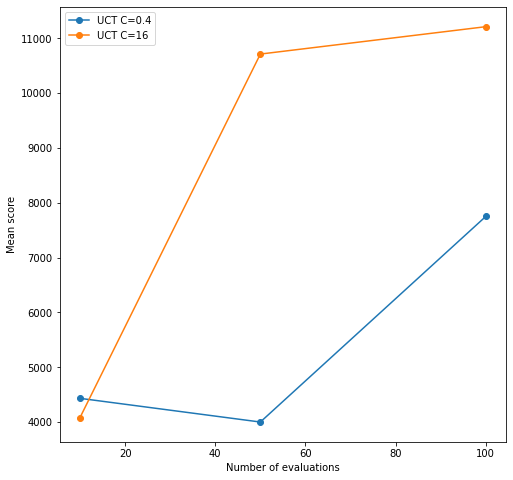

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], uct_scores[:-1], marker='o', label='UCT C=0.4')
ax1.plot([10, 50, 100], uct_scores_c16, marker='o', label='UCT C=16')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Mean score')
plt.legend()
plt.show()

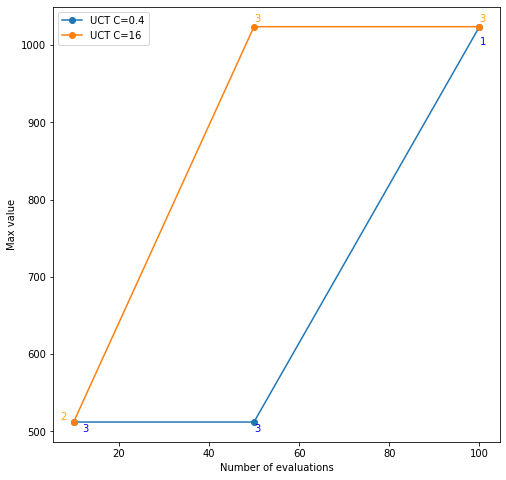

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], uct_max[:-1], marker='o', label='UCT C=0.4')
ax1.plot([10, 50, 100], uct_max_c16, marker='o', label='UCT C=16')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Max value')

ax1.annotate(np.count_nonzero(uct10_max == np.max(uct10_max)), xy=(12, 500), color='blue')
ax1.annotate(np.count_nonzero(uct50_max == np.max(uct50_max)), xy=(50, 500), color='blue')
ax1.annotate(np.count_nonzero(uct100_max == np.max(uct100_max)), xy=(100, 1000), color='blue')

ax1.annotate(np.count_nonzero(uct10_max_c16 == np.max(uct10_max_c16)), xy=(7, 515), color='orange')
ax1.annotate(np.count_nonzero(uct50_max_c16 == np.max(uct50_max_c16)), xy=(50, 1030), color='orange')
ax1.annotate(np.count_nonzero(uct100_max_c16 == np.max(uct100_max_c16)), xy=(100, 1030), color='orange')

plt.legend()
plt.show()

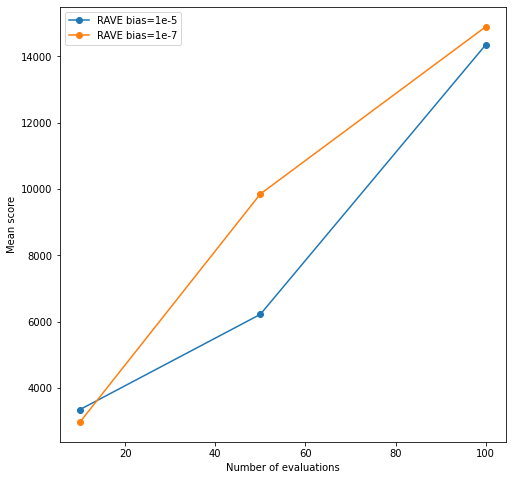

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], rave_scores[:-1], marker='o', label='RAVE bias=1e-5')
ax1.plot([10, 50, 100], rave_scores_b7, marker='o', label='RAVE bias=1e-7')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Mean score')
plt.legend()
plt.show()

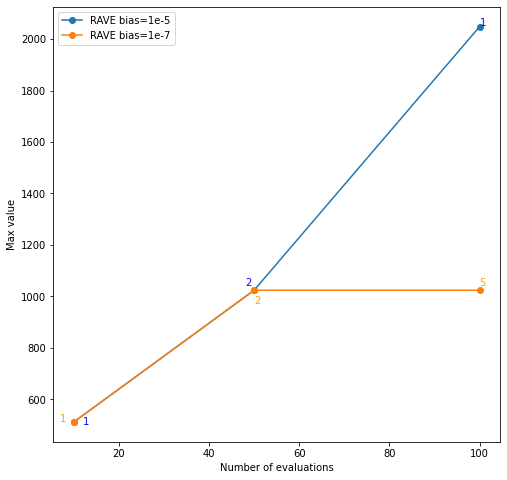

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], rave_max[:-1], marker='o', label='RAVE bias=1e-5')
ax1.plot([10, 50, 100], rave_max_b7, marker='o', label='RAVE bias=1e-7')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Max value')

ax1.annotate(np.count_nonzero(rave10_max == np.max(rave10_max)), xy=(12, 500), color='blue')
ax1.annotate(np.count_nonzero(rave50_max == np.max(rave50_max)), xy=(48, 1040), color='blue')
ax1.annotate(np.count_nonzero(rave100_max == np.max(rave100_max)), xy=(100, 2050), color='blue')

ax1.annotate(np.count_nonzero(rave10_max_b7 == np.max(rave10_max_b7)), xy=(7, 515), color='orange')
ax1.annotate(np.count_nonzero(rave50_max_b7 == np.max(rave50_max_b7)), xy=(50, 970), color='orange')
ax1.annotate(np.count_nonzero(rave100_max_b7 == np.max(rave100_max_b7)), xy=(100, 1040), color='orange')

plt.legend()
plt.show()

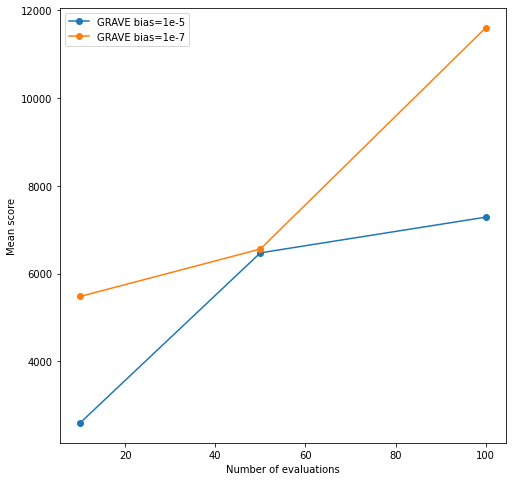

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], grave_scores[:-1], marker='o', label='GRAVE bias=1e-5')
ax1.plot([10, 50, 100], grave_scores_b7, marker='o', label='GRAVE bias=1e-7')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Mean score')
plt.legend()
plt.show()

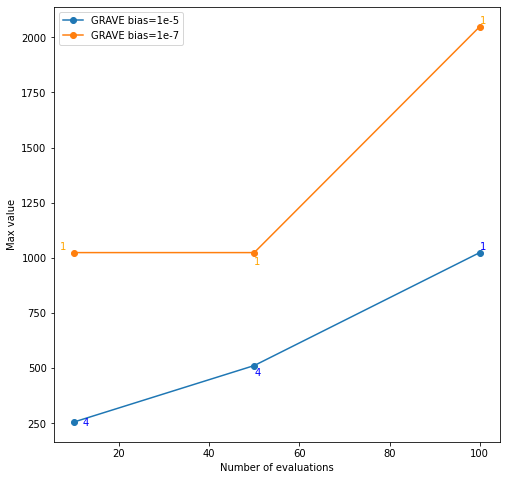

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], grave_max[:-1], marker='o', label='GRAVE bias=1e-5')
ax1.plot([10, 50, 100], grave_max_b7, marker='o', label='GRAVE bias=1e-7')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Max value')

ax1.annotate(np.count_nonzero(grave10_max == np.max(grave10_max)), xy=(12, 240), color='blue')
ax1.annotate(np.count_nonzero(grave50_max == np.max(grave50_max)), xy=(50, 465), color='blue')
ax1.annotate(np.count_nonzero(grave100_max == np.max(grave100_max)), xy=(100, 1035), color='blue')

ax1.annotate(np.count_nonzero(grave10_max_b7 == np.max(grave10_max_b7)), xy=(7, 1035), color='orange')
ax1.annotate(np.count_nonzero(grave50_max_b7 == np.max(grave50_max_b7)), xy=(50, 970), color='orange')
ax1.annotate(np.count_nonzero(grave100_max_b7 == np.max(grave100_max_b7)), xy=(100, 2060), color='orange')

plt.legend()
plt.show()

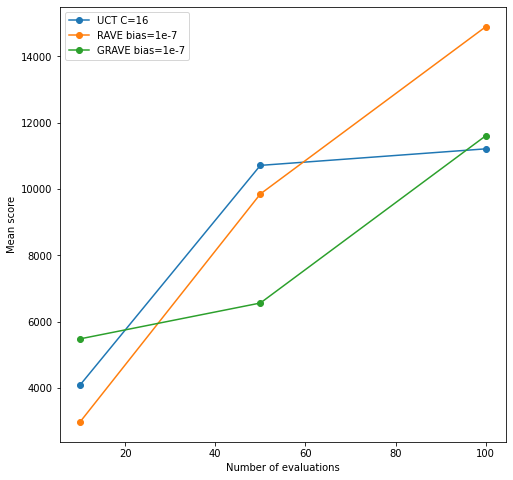

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], uct_scores_c16, marker='o', label='UCT C=16')
ax1.plot([10, 50, 100], rave_scores_b7, marker='o', label='RAVE bias=1e-7')
ax1.plot([10, 50, 100], grave_scores_b7, marker='o', label='GRAVE bias=1e-7')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Mean score')
plt.legend()
plt.show()

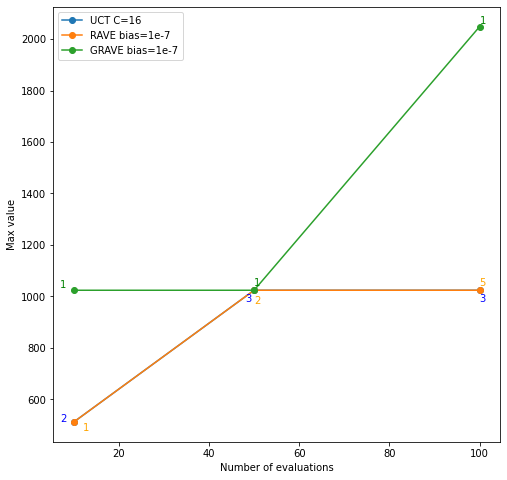

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100], uct_max_c16, marker='o', label='UCT C=16')
ax1.plot([10, 50, 100], rave_max_b7, marker='o', label='RAVE bias=1e-7')
ax1.plot([10, 50, 100], grave_max_b7, marker='o', label='GRAVE bias=1e-7')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Max value')

ax1.annotate(np.count_nonzero(uct10_max_c16 == np.max(uct10_max_c16)), xy=(7, 515), color='blue')
ax1.annotate(np.count_nonzero(uct50_max_c16 == np.max(uct50_max_c16)), xy=(48, 980), color='blue')
ax1.annotate(np.count_nonzero(uct100_max_c16 == np.max(uct100_max_c16)), xy=(100, 980), color='blue')

ax1.annotate(np.count_nonzero(rave10_max_b7 == np.max(rave10_max_b7)), xy=(12, 480), color='orange')
ax1.annotate(np.count_nonzero(rave50_max_b7 == np.max(rave50_max_b7)), xy=(50, 970), color='orange')
ax1.annotate(np.count_nonzero(rave100_max_b7 == np.max(rave100_max_b7)), xy=(100, 1040), color='orange')

ax1.annotate(np.count_nonzero(grave10_max_b7 == np.max(grave10_max_b7)), xy=(7, 1035), color='green')
ax1.annotate(np.count_nonzero(grave50_max_b7 == np.max(grave50_max_b7)), xy=(50, 1040), color='green')
ax1.annotate(np.count_nonzero(grave100_max_b7 == np.max(grave100_max_b7)), xy=(100, 2060), color='green')

plt.legend()
plt.show()

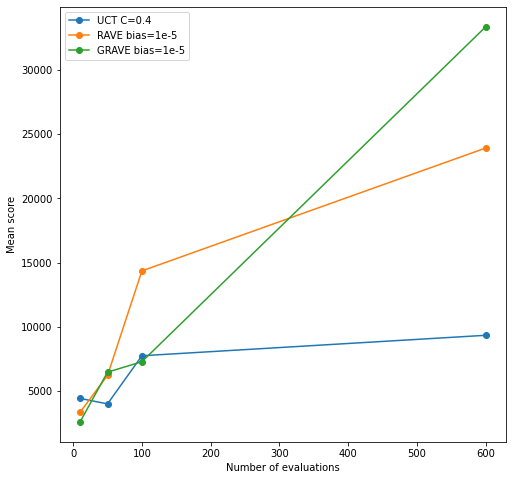

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100, 600], uct_scores, marker='o', label='UCT C=0.4')
ax1.plot([10, 50, 100, 600], rave_scores, marker='o', label='RAVE bias=1e-5')
ax1.plot([10, 50, 100, 600], grave_scores, marker='o', label='GRAVE bias=1e-5')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Mean score')
plt.legend()
plt.show()

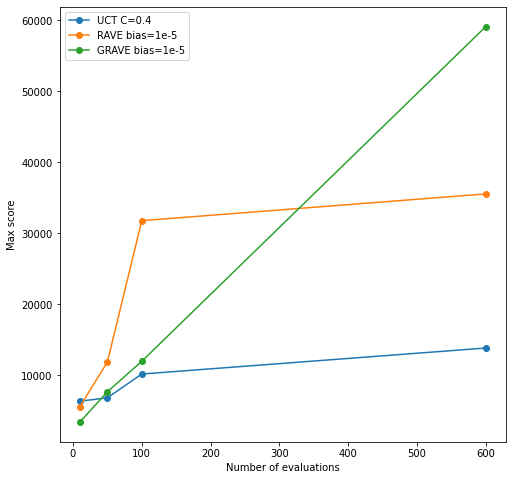

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100, 600], uct_scores_max, marker='o', label='UCT C=0.4')
ax1.plot([10, 50, 100, 600], rave_scores_max, marker='o', label='RAVE bias=1e-5')
ax1.plot([10, 50, 100, 600], grave_scores_max, marker='o', label='GRAVE bias=1e-5')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Max score')
plt.legend()
plt.show()

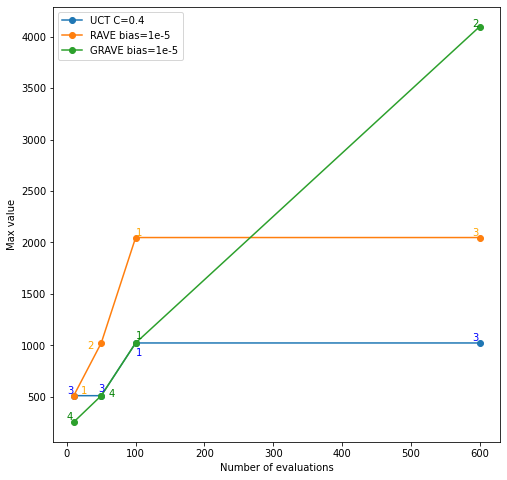

In [ ]:
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot([10, 50, 100, 600], uct_max, marker='o', label='UCT C=0.4')
ax1.plot([10, 50, 100, 600], rave_max, marker='o', label='RAVE bias=1e-5')
ax1.plot([10, 50, 100, 600], grave_max, marker='o', label='GRAVE bias=1e-5')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Max value')

ax1.annotate(np.count_nonzero(uct10_max == np.max(uct10_max)), xy=(0, 530), color='blue')
ax1.annotate(np.count_nonzero(uct50_max == np.max(uct50_max)), xy=(45, 550), color='blue')
ax1.annotate(np.count_nonzero(uct100_max == np.max(uct100_max)), xy=(100, 900), color='blue')
ax1.annotate(np.count_nonzero(uct600_max == np.max(uct600_max)), xy=(590, 1050), color='blue')

ax1.annotate(np.count_nonzero(rave10_max == np.max(rave10_max)), xy=(20, 530), color='orange')
ax1.annotate(np.count_nonzero(rave50_max == np.max(rave50_max)), xy=(30, 970), color='orange')
ax1.annotate(np.count_nonzero(rave100_max == np.max(rave100_max)), xy=(100, 2070), color='orange')
ax1.annotate(np.count_nonzero(rave600_max == np.max(rave600_max)), xy=(590, 2070), color='orange')

ax1.annotate(np.count_nonzero(grave10_max == np.max(grave10_max)), xy=(0, 280), color='green')
ax1.annotate(np.count_nonzero(grave50_max == np.max(grave50_max)), xy=(60, 500), color='green')
ax1.annotate(np.count_nonzero(grave100_max == np.max(grave100_max)), xy=(100, 1070), color='green')
ax1.annotate(np.count_nonzero(grave600_max == np.max(grave600_max)), xy=(590, 4100), color='green')

plt.legend()
plt.show()

In [ ]:
def para_alea(x, board, move):
    cop = copy.deepcopy(board)
    cop.play(move)
    return  cop.playout()

def MCTS(board, n_sim):
    moves = board.available_moves
    moves_scores = [0] * len(moves)

    for i in range(len(moves)):
        with Pool(5) as p:
            L = p.map(partial(para_alea, board = board, move = moves[i]), range(n_sim))
        moves_scores[i] = sum(L)
    return moves[np.argmax(moves_scores)]

In [ ]:
b = Board()
while not(b.game_over()):
    b.play(MCTS(b, 100))
print(b.board.max())

2048